## Dataset Structure
The raw dataset of synthetic images consists of scenes labeled by scene number (i.e., scene_0, scene_1,...,etc) with each scene containing an instance folder and a photo folder and some files that will be parsed for information regarding each object instance in a given scene. 
- The instance folder contains 300 instance images which contain the information of object instances labels for the trajectory of a scene. The instance labels are kept the same throughout all frames.  
- The photo folder contains the rgb photorealistic image. 
- The files that will be parsed are scene_and_trajectory_description.txt and render_info.log. These files contain information about the object ShapeNet directory, WordNet ID, Scale, Transformation Matrix, and Object Instance ID

Overall the structure is somethings like
```
$DATA_PATH
├── scenes
│   ├── scene_0
|       ├── instance 
|       ├── photo 
|       ├── scene_description_0.txt
|       ├── scene_and_trajectory_description_0_0.txt
|       ├── render_info_0_0.log
|   .
|   .
|   .
```

## Filtering Out Useless Frames
We want to filter out the images/frames that consists of just walls, floors, ceilings, or very small amount of visible objects. A quick way to do this is to take the minimum and maximum amount of objects visible in a given scene and get the average and set that as the threshold of objects we need to see in order to use the image/frame

In [8]:
# Utilities
import os
import json
import pprint as pprint
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection
from skimage import io

# cocoapi for encode instance image into rle byte string
import cocoapi.PythonAPI.pycocotools.mask as mask

# parsing functions
import parse_files

We need to pair up the instance and rgb images together because as it stands each image is in its own folder. We also need to store the log files for each scene.

In [9]:
# location of scenes
scenes_dir = "../scenes/"

# store the photorealistic images, object instance images, and log files
rgb_images = []
instance_images = []
logs = []

# recuse through the scenes directory and store the rgb, instance, and log files
for subdir, dirs, files in os.walk(scenes_dir):
    for file in files:
        
        file_path = os.path.join(subdir, file)
        
        # store the rgb image
        if 'photo' in file_path:
            rgb_images.append(file_path)
        
        # store the instance image
        if 'instance' in file_path:
            instance_images.append(file_path)
            
        # store log files
        if 'render' in file_path or 'scene_and_trajectory' in file_path:
            logs.append(file_path)

# put the log files into a list of tuples
paired_logs = list(zip(logs[0::2], logs[1::2]))

# make a list of the list of tupled log files
scenes = [[log] for log in paired_logs]

# utility functions
get_frame_num = lambda x: x.split('/')[-1].split('_')[0]
get_scene_num = lambda x: x.split('/')[-3]


# match up the rgb and instance frame numbers with respect to the scene number
paired_images = [(rgb, instance) for rgb in rgb_images for instance in instance_images
                if get_frame_num(rgb) == get_frame_num(instance) and get_scene_num(rgb) == get_scene_num(instance)]


# add the paired iamges to the correct scene number in the scenes list
for scene in scenes:
    imgs = []
    for img in paired_images:
        if scene[0][0].split('/')[-2] == get_scene_num(img[0]):
            imgs.append(img)
        scene.append(imgs)

The file ```train_split_filtered_model_info_and_texture.txt``` contains information about each object of ShapeNet that can be used as a lookup table.

In [10]:
text_file = 'src/scene_generator/textfiles/train_split_filtered_model_info_and_texture.txt'

if os.path.exists("shapenet_dir_and_object_ids.json"):
    print("JSON already exists")
else:
    lookup = parse_files.make_object_lookup(text_file)
    with open("shapenet_dir_and_object_ids.json", "w") as write_file:
        json.dump(lookup, write_file)
with open("shapenet_dir_and_object_ids.json", "r") as read_file:
    name_lookup = json.load(read_file)


JSON already exists


In [74]:
# These will contain the frame numbers and images 
# that were above the average
# object threshold for the respective scene number
scene_number_and_viable_frames = []
scene_number_and_viable_images = []

# storing a list of all the viable images
_images = []

for ii, scene in enumerate(scenes):
    # get the render and description files
    render_log = scene[0][1] if "render" in scene[0][1] else scene[0][0]
    description_file = scene[0][0] if "scene_and_trajectory" in scene[0][0] else scene[0][1]
#     print(render_log, description_file)
    # get the information from the scene_and_trajectory_description file
    layout_lines = parse_files.get_text_layout_lines(description_file)
    processed_objects = parse_files.process_objects_into_instances(layout_lines)
    
    # get the information from the render_info.log file
    log_lines = parse_files.get_info_log_lines(render_log)
    objects_in_scene_info = parse_files.get_instances(log_lines)
    
    
    # loop through the information in processed_objects
    # matching the shapenet hash keys to the entries in
    # the objects_in_scene_info and update the 'wnid' and 'english'
    # fields for each object
    # this will contain some the information we need to put
    # in the JSON file we still need to get the bbox, pixel area
    # and segmentation
    for po in processed_objects:
        for obj in objects_in_scene_info:
            if obj['hash'] is not None and obj['hash'] == po['hash']:
                # update wnid since it is empty in the 
                obj['wnid'] = po['wnid']
                
                # update 'english' by using name_lookup file
                obj['english'] = name_lookup[obj['hash']][obj['wnid']][0]
                
                
    
    # store the scene number
    scene_num = render_log.split('/')[-2]
    
    # frames/images we want to use
    viable_frames = []
    viable_images = []
    
    scene_number_and_viable_frames.append([scene_num])
    scene_number_and_viable_images.append([scene_num])
    
    # store the number of objects in instance image
    num_objs_in_image = []
    
    # loop through the images in the scene
    # getting the number of objects in each image
    # and storing those values to later be used
    # to get the minimum and maximum amount of
    # objects for the given scene
    for images in scene[1]:
        # get the instance image with the object instance labels
        iimg = io.imread(images[1])
        
        # make an array with the object instance ids
        obj_ids = np.unique(iimg)
#         print(obj_ids)
        # the instance image with object instance ids always
        # contains a value of 0 for the background so we do a -1
        num_objs_in_image.append(len(obj_ids)-1)
        
    min_objs = min(num_objs_in_image)
    max_objs = max(num_objs_in_image)
    
    avg_objs = np.ceil((min_objs + max_objs) / 2)
#     print(f"\n{scene_num}: Max number of object {max_objs}, Minimum number of objects {min_objs} Average number of objects {avg_objs}")

    # now that we have the threshold we can loop through the 
    # images in the scene and storing only the ones that are 
    # above the threshold
    for images in scene[1]:
        iimg = images[1]
        frame_num = get_frame_num(iimg)
        img = io.imread(iimg)
        
        # store the current image's object instance ids
        objs_iids = np.unique(img)
        
#         print(obj_ids)
        # for each entry in the objects_in_scene_info file
        # if the 'instance_num' is in the objs_ids list,
        # and its 'hash' is not empty and it is above the object threshold
        # we add this frame
        for obj_info in objects_in_scene_info:
            if obj_info['instance_num'] in objs_iids and obj_info['hash'] is not None and len(objs_iids) > avg_objs:
                viable_frames.append(frame_num)
    
    viable_frames = np.unique(viable_frames)
                    
#     print(f"\nusable frames: {len(viable_frames)}")
      
    scene_number_and_viable_frames[ii].append(viable_frames)
    
    for images in scene[1]:
        rgb = images[0]
        iimg = images[1]
        frame_num = get_frame_num(rgb)
        
        # check if the current frame number is in the 
        # viable_frames list 
        if frame_num in scene_number_and_viable_frames[ii][1]:
            # add current rgb photo
            viable_images.append((rgb, iimg))
            _images.append((rgb, iimg))
    scene_number_and_viable_images[ii].append(viable_images)
#     print(f"\nusable images: {len(viable_images)}\n")
    
    for images in scene[1]:
        rgb_file = images[0]
        iimg = images[1]
        
        sn, fn = get_scene_num(rgb_file).split('_')[1], get_frame_num(rgb_file)
        
        instance_png = io.imread(iimg)
        
        obj_instances = np.unique(instance_png)
        obj_instances = obj_instances.tolist()
#         print(obj_instances)
        
        data['images'].append({
        'license': data['licenses'][0]['id'],
        'file_name': rgb_file,
        'coco_url': None,
        'height': 240,
        'width': 320,
        'date_captured': None,
        'flickr_url': None,
        'id': "0"+sn+"0"+fn, # 0 + scene_number + 0 + frame_number
        })
        
        for obj_info in objects_in_scene_info:
            if obj_info["instance_num"] in obj_instances and obj_info["hash"] is not None:
                iid = obj_instances[obj_instances.index(obj_info["instance_num"])]
#                 print(iid)
                wnid = obj_info["wnid"]
#                 print(wnid)
                name = obj_info["english"]
                obj = instance_png==iid
                area = len(np.where(obj)[0]) + len(np.where(obj)[1])
                
                ymin = np.where(instance_png==iid)[0].min()
                ymax = np.where(instance_png==iid)[0].max()

                xmin = np.where(instance_png==iid)[1].min()
#                 print(xmin)
                xmax = np.where(instance_png==iid)[1].max()

                width = xmax-xmin
#                 print(width)
                height =  ymax-ymin
#                 print(height)
                rle = mask.encode(np.asfortranarray(obj.astype(np.uint8)))
                trle = {
                    'counts': rle['counts'].decode("utf-8"),
                    'size': rle['size'],
                }
#                 print(trle)
            data['annotations'].append({
                'id':int(iid), # object instance id
                'category_id': wnid,
                'bbox': [int(xmin), int(ymin), int(width), int(height)],
                'image_id': data['images'][ii]['id'],
                'iscrowd': None,
                'area': area,
                'segmentation': trle,
            })

            data['categories'].append({
                'supercategory': "",
                'id':  data['annotations'][ii]['category_id'], # wordnet id,
                'name': name,
            })
                
    
        
        
            

        
    
# write data object to json file
with open("instance.json", "w") as write_file:
    json.dump(data, write_file)
    
        
    
    



In [73]:
data = {
    'info': {
        'description': "Autonomous Robotics and Perception Group Synthetic Images Dataset(ARPG-SID). ",
        'url': None,
        'version': 1,
        'year': 2018,
        'contributor': "Juan Vargas-Murillo",
        'date_created': None,
        
    },
    'images':[ ],
    'licenses':[
        {
            'url': "https://creativecommons.org/licenses/",
            'id': 0,
            'name': "creative commons",
        }
    ],
    'annotations':[ ],
    'categories':[ ],
}



In [70]:
# write data object to json file
with open("instance.json", "w") as write_file:
    json.dump(data, write_file)
    
    

In [75]:
with open("instance.json", "r") as read_file:
    json_data = json.load(read_file)

In [77]:
json_data["annotations"]

[{'area': 18,
  'bbox': [312, 236, 4, 3],
  'category_id': '03710193',
  'id': 88,
  'image_id': '01502750',
  'iscrowd': None,
  'segmentation': {'counts': '_[Y21]71012O0OQ?', 'size': [240, 320]}},
 {'area': 18,
  'bbox': [312, 236, 4, 3],
  'category_id': '03710193',
  'id': 88,
  'image_id': '01502750',
  'iscrowd': None,
  'segmentation': {'counts': '_[Y21]71012O0OQ?', 'size': [240, 320]}},
 {'area': 18,
  'bbox': [312, 236, 4, 3],
  'category_id': '03710193',
  'id': 88,
  'image_id': '01502750',
  'iscrowd': None,
  'segmentation': {'counts': '_[Y21]71012O0OQ?', 'size': [240, 320]}},
 {'area': 18,
  'bbox': [312, 236, 4, 3],
  'category_id': '03710193',
  'id': 88,
  'image_id': '01502750',
  'iscrowd': None,
  'segmentation': {'counts': '_[Y21]71012O0OQ?', 'size': [240, 320]}},
 {'area': 18,
  'bbox': [312, 236, 4, 3],
  'category_id': '03710193',
  'id': 88,
  'image_id': '01502750',
  'iscrowd': None,
  'segmentation': {'counts': '_[Y21]71012O0OQ?', 'size': [240, 320]}},
 {'ar

In [1]:
test_img = io.imread("../scenes/scene_15/instance/2750_instance.png")
# plt.imshow(test_img==15)
# plt.show()

# print(np.unique(test_img))

NameError: name 'io' is not defined

In [83]:
arr = mask.decode(data['annotations'][14]['segmentation'])

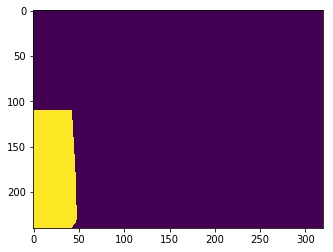

In [84]:
plt.imshow(arr)